In [ ]:
# Install CLIP package
!pip install git+https://github.com/openai/CLIP.git
import os
import zipfile
import random
import torch
import clip
import numpy as np
from PIL import Image
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from tqdm import tqdm
from google.colab import drive

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vencambc
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vencambc
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to ZIP file and extract location
zip_path = "/content/drive/My Drive/Adversarial Signs/Triggers_v2/triggers.zip"
extract_path = "/content/triggers/triggers/"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

# Paths to output_images
base_path = os.path.join(extract_path, "output_images_cifar10")
clean_path = os.path.join(base_path, "clean")
attack_folders = ["badnets_pixels", "badnets_square", "l0_inv", "l2_inv", "trojan_sq", "trojan_wm"]

Mounted at /content/drive
Files extracted to: /content/triggers/triggers/


In [ ]:
# Specify the unseen attack
unseen_attack = "badnets_pixels"
train_attack_folders = [folder for folder in attack_folders if folder != unseen_attack]

print(f"Training attack folders: {train_attack_folders}")
print(f"Unseen attack folder: {unseen_attack}")

# Prepare the dataset
def prepare_clip_data():
    print("Preparing data...")

    # Define paths to train and test folders
    train_clean_path = os.path.join(base_path, "train", "clean")
    test_clean_path = os.path.join(base_path, "test", "clean")

    # Collect all train and test clean images
    train_clean = [os.path.join(train_clean_path, img) for img in os.listdir(train_clean_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
    test_clean = [os.path.join(test_clean_path, img) for img in os.listdir(test_clean_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Training clean images: {len(train_clean)}, Testing clean images: {len(test_clean)}")

    # Collect attack images for training
    train_attacks = []
    for folder in train_attack_folders:
        attack_path = os.path.join(base_path, "train", folder)
        attack_images = [os.path.join(attack_path, img) for img in os.listdir(attack_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        sampled_attacks = random.sample(attack_images, len(train_clean) // len(train_attack_folders))  # Balance with clean images
        train_attacks += sampled_attacks
        print(f"Sampled {len(sampled_attacks)} images from {folder} for training.")

    # Collect unseen attack images for testing
    unseen_attack_path = os.path.join(base_path, "test", unseen_attack)
    unseen_attack_images = [os.path.join(unseen_attack_path, img) for img in os.listdir(unseen_attack_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
    test_unseen = random.sample(unseen_attack_images, len(test_clean))  # Match clean test size
    print(f"Number of unseen attack images for testing: {len(test_unseen)}")

    # Combine data and labels
    train_data = [(img, 0) for img in train_clean] + [(img, 1) for img in train_attacks]
    test_data = [(img, 0) for img in test_clean] + [(img, 1) for img in test_unseen]

    # Shuffle both datasets
    random.shuffle(train_data)
    random.shuffle(test_data)

    print(f"Training dataset size: {len(train_data)}, Testing dataset size: {len(test_data)}")
    return train_data, test_data

Training attack folders: ['badnets_square', 'l0_inv', 'l2_inv', 'trojan_sq', 'trojan_wm']
Unseen attack folder: badnets_pixels


In [ ]:
# Custom PyTorch dataset
class CLIPDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        return img, label

# Preprocessing for CLIP
preprocess = Compose([
    Resize((224, 224)),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

# Prepare datasets
train_data, test_data = prepare_clip_data()

train_dataset = CLIPDataset(train_data, transform=preprocess)
test_dataset = CLIPDataset(test_data, transform=preprocess)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training data: {len(train_dataset)}, Testing data: {len(test_dataset)}")

Preparing data...
Training clean images: 50000, Testing clean images: 10000
Sampled 10000 images from badnets_square for training.
Sampled 10000 images from l0_inv for training.
Sampled 10000 images from l2_inv for training.
Sampled 10000 images from trojan_sq for training.
Sampled 10000 images from trojan_wm for training.
Number of unseen attack images for testing: 10000
Training dataset size: 100000, Testing dataset size: 20000
Training data: 100000, Testing data: 20000


In [ ]:
# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)
model = model.float()

# Define label mapping and prompts
label_map = {0: "clean", 1: "adversarial"}
full_prompts = [f"a photo of {label_map[label]}" for label in label_map.keys()]

# Tokenize prompts
full_token_ids = clip.tokenize(full_prompts).to(device)
print(f"Tokenized prompts: {full_prompts}")

# Get the token embeddings for the full prompts
with torch.no_grad():
    full_token_embeddings = model.token_embedding(full_token_ids).type(model.dtype)

# Identify the prefix length
prefix = "a photo of"
prefix_token_ids = clip.tokenize(prefix).to(device)
prefix_length = prefix_token_ids.ne(0).sum().item()
print(f"Prefix length: {prefix_length}")

100%|███████████████████████████████████████| 335M/335M [00:03<00:00, 88.5MiB/s]


Tokenized prompts: ['a photo of clean', 'a photo of adversarial']
Prefix length: 5


In [ ]:
# Tokenize "a photo of" to extract embeddings
prefix_tokens = clip.tokenize("a photo of").to(device)

# Extract the token embeddings for "a photo of"
with torch.no_grad():
    prefix_embeddings = model.token_embedding(prefix_tokens).squeeze(0)

# Set the prefix embeddings as learnable parameters
prefix_embeddings = nn.Parameter(prefix_embeddings[:prefix_length])  # Ensure correct prefix length

In [ ]:
# Freeze other parts of the text encoder
for param in model.parameters():
    param.requires_grad = False

# Allow the prefix embeddings and visual model to train
model.visual.requires_grad = False

NameError: name 'nn' is not defined

In [ ]:
# Define the custom text encoder
class CustomTextEncoder(nn.Module):
    def __init__(self, clip_model, prefix_embeddings, full_token_ids, prefix_length):
        super(CustomTextEncoder, self).__init__()
        self.clip_model = clip_model
        self.prefix_embeddings = prefix_embeddings
        self.full_token_ids = full_token_ids
        self.prefix_length = prefix_length
        self.token_embedding = clip_model.token_embedding
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self):
        num_classes = self.full_token_ids.size(0)
        token_embeddings = self.token_embedding(self.full_token_ids).type(self.dtype)
        token_embeddings[:, :self.prefix_length, :] = self.prefix_embeddings.unsqueeze(0).expand(num_classes, -1, -1).type(self.dtype)
        positional_embeddings = self.positional_embedding[:token_embeddings.size(1), :].type(self.dtype)
        x = token_embeddings + positional_embeddings
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)
        x = self.ln_final(x).type(self.dtype)
        eos_indices = self.full_token_ids.argmax(dim=-1)
        x = x[torch.arange(x.shape[0]), eos_indices] @ self.text_projection
        return x

# Initialize the custom text encoder
text_encoder = CustomTextEncoder(model, prefix_embeddings, full_token_ids, prefix_length).to(device)

In [ ]:
# Prompt adapter module

# Define the classifier model
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, text_encoder):
        super(CLIPClassifier, self).__init__()
        self.clip_model = clip_model
        self.text_encoder = text_encoder

    def forward(self, images):
        image_embeddings = self.clip_model.encode_image(images)
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
        text_embeddings = self.text_encoder()
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
        logits = 100.0 * image_embeddings @ text_embeddings.T
        return logits

# Initialize the model and optimizer
classifier_model = CLIPClassifier(model, text_encoder).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam([
    {'params': classifier_model.text_encoder.prefix_embeddings, 'lr': 1e-5}
])

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    classifier_model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier_model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

from sklearn.metrics import f1_score

# Evaluation
classifier_model.eval()
all_predictions = []
all_labels = []
correct, total = 0, 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        logits = classifier_model(images)
        predictions = torch.argmax(logits, dim=1)

        # Collect predictions and labels for F1 score computation
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Compute accuracy
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Calculate F1 score (macro or weighted based on your needs)
f1 = f1_score(all_labels, all_predictions, average='macro')  # Use 'weighted' for weighted F1
print(f"F1 Score (Macro): {f1:.4f}")


100%|██████████| 782/782 [09:25<00:00,  1.38it/s]


Epoch 1/10, Loss: 0.8101


100%|██████████| 782/782 [09:23<00:00,  1.39it/s]


Epoch 2/10, Loss: 0.6322


100%|██████████| 782/782 [09:24<00:00,  1.39it/s]


Epoch 3/10, Loss: 0.5337


100%|██████████| 782/782 [09:24<00:00,  1.39it/s]


Epoch 4/10, Loss: 0.4457


100%|██████████| 782/782 [09:24<00:00,  1.39it/s]


Epoch 5/10, Loss: 0.3726


100%|██████████| 782/782 [09:23<00:00,  1.39it/s]


Epoch 6/10, Loss: 0.3315


100%|██████████| 782/782 [09:23<00:00,  1.39it/s]


Epoch 7/10, Loss: 0.3061


100%|██████████| 782/782 [09:23<00:00,  1.39it/s]


Epoch 8/10, Loss: 0.2867


100%|██████████| 782/782 [09:23<00:00,  1.39it/s]


Epoch 9/10, Loss: 0.2692


100%|██████████| 782/782 [09:23<00:00,  1.39it/s]


Epoch 10/10, Loss: 0.2524


100%|██████████| 157/157 [01:30<00:00,  1.74it/s]


Test Accuracy: 59.38%
F1 Score (Macro): 0.5380


100%|██████████| 198/198 [01:47<00:00,  1.85it/s]


Test Accuracy: 62.76%
F1 Score (Macro): 0.6249


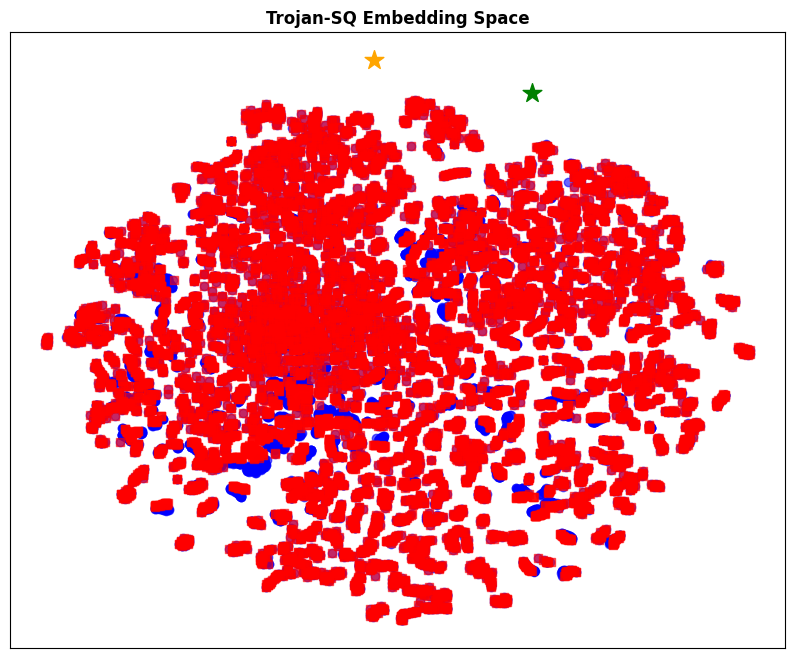

In [ ]:
# Evaluation loop (modified to extract embeddings)
image_embeddings_list = []
text_embeddings_list = []
labels_list = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        logits = classifier_model(images)
        predictions = torch.argmax(logits, dim=1)

        # Collect predictions and labels for F1 score computation
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Extract and normalize embeddings
        image_embeddings = classifier_model.clip_model.encode_image(images)
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
        text_embeddings = classifier_model.text_encoder()
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

        # Append embeddings and labels
        image_embeddings_list.append(image_embeddings.cpu().numpy())
        text_embeddings_list.append(text_embeddings.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

        # Compute accuracy
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

accuracy = 100 * correct / total
f1 = f1_score(all_labels, all_predictions, average='macro')
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"F1 Score (Macro): {f1:.4f}")

# Visualization block
image_embeddings_array = np.vstack(image_embeddings_list)
text_embeddings_array = np.vstack(text_embeddings_list)
labels_array = np.array(labels_list)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(np.vstack((image_embeddings_array, text_embeddings_array)))

# Split embeddings
num_images = len(image_embeddings_array)
reduced_image_embeddings = reduced_embeddings[:num_images]
reduced_text_embeddings = reduced_embeddings[num_images:]

# Plot
plt.figure(figsize=(10, 8))
for label, color, marker in zip([0, 1], ['blue', 'red'], ['o', 's']):
    indices = labels_array == label
    plt.scatter(reduced_image_embeddings[indices, 0], reduced_image_embeddings[indices, 1],
                color=color, marker=marker, label=f"Image Embeddings ({'Clean' if label == 0 else 'Unseen Adversarial'})", alpha=0.6)

plt.scatter(reduced_text_embeddings[0, 0], reduced_text_embeddings[0, 1],
            color='orange', marker='*', s=200, label="Text Embedding (Clean)")
plt.scatter(reduced_text_embeddings[1, 0], reduced_text_embeddings[1, 1],
            color='green', marker='*', s=200, label="Text Embedding (Adversarial)")

plt.title("Trojan-SQ Embedding Space", fontweight='bold')
plt.xlabel("")
plt.ylabel("")

# Remove values on x and y axes
plt.xticks([])
plt.yticks([])

#plt.legend()
plt.grid(False)  # Remove grid
plt.show()


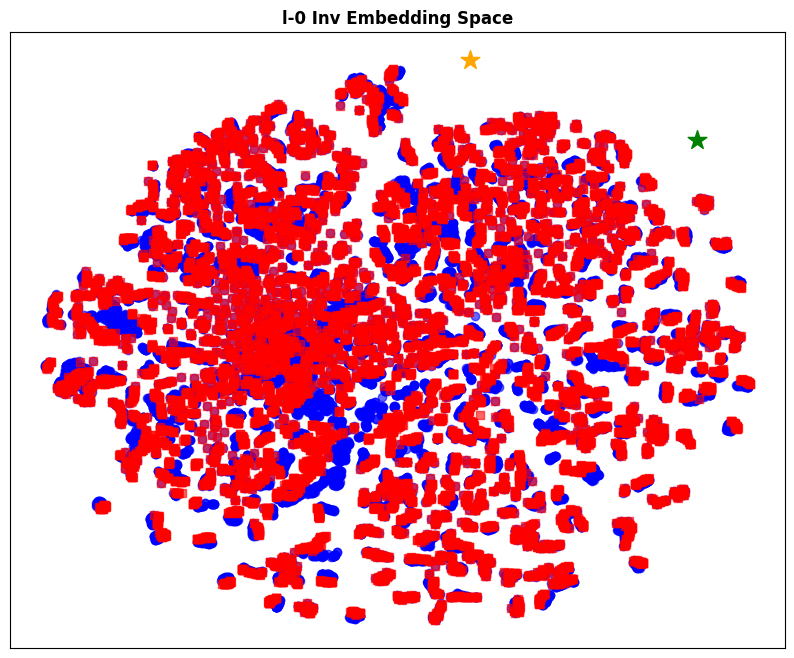

In [ ]:
# Plot
plt.figure(figsize=(10, 8))
for label, color, marker in zip([0, 1], ['blue', 'red'], ['o', 's']):
    indices = labels_array == label
    plt.scatter(reduced_image_embeddings[indices, 0], reduced_image_embeddings[indices, 1],
                color=color, marker=marker, label=f"Image Embeddings ({'Clean' if label == 0 else 'Unseen Adversarial'})", alpha=0.6)

plt.scatter(reduced_text_embeddings[0, 0], reduced_text_embeddings[0, 1],
            color='orange', marker='*', s=200, label="Text Embedding (Clean)")
plt.scatter(reduced_text_embeddings[1, 0], reduced_text_embeddings[1, 1],
            color='green', marker='*', s=200, label="Text Embedding (Adversarial)")

plt.title("l-0 Inv Embedding Space", fontweight='bold')
plt.xlabel("")
plt.ylabel("")

# Remove values on x and y axes
plt.xticks([])
plt.yticks([])

#plt.legend()
plt.grid(False)  # Remove grid
plt.show()
